## Load data

In [2]:
import pickle

f = open('/work/fMRI_analysis/model.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()

### Define subject number

In [3]:
print(models)
subject_nr = 7

# Checking if we have the right subject (should be 0122)
print(models[subject_nr])

[FirstLevelModel(n_jobs=6, subject_label='0117', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0116', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0118', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0121', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0120', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0123', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0119', t_r=1), FirstLevelModel(n_jobs=6, subject_label='0122', t_r=1)]
FirstLevelModel(n_jobs=6, subject_label='0122', t_r=1)


## Design matrix

In [4]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

# Changing the model for a single participant (the first):
for ii in range(len(models_events[0])):
    # Sort onsets by trial type to make later processing easier
    #models_events[0][ii].sort_values(by=['trial_type'], inplace=True)
     #N=number of events
    N=models_events[0][ii].shape[0]
    # time frame with 490 scans with 1s TR:
    t_fmri = np.linspace(0, 490,490,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[0][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = [models_events[0][ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[0][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))

/home/ucloud/.local/lib/python3.10/site-packages/nilearn/glm/_utils.py:321: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


### Print

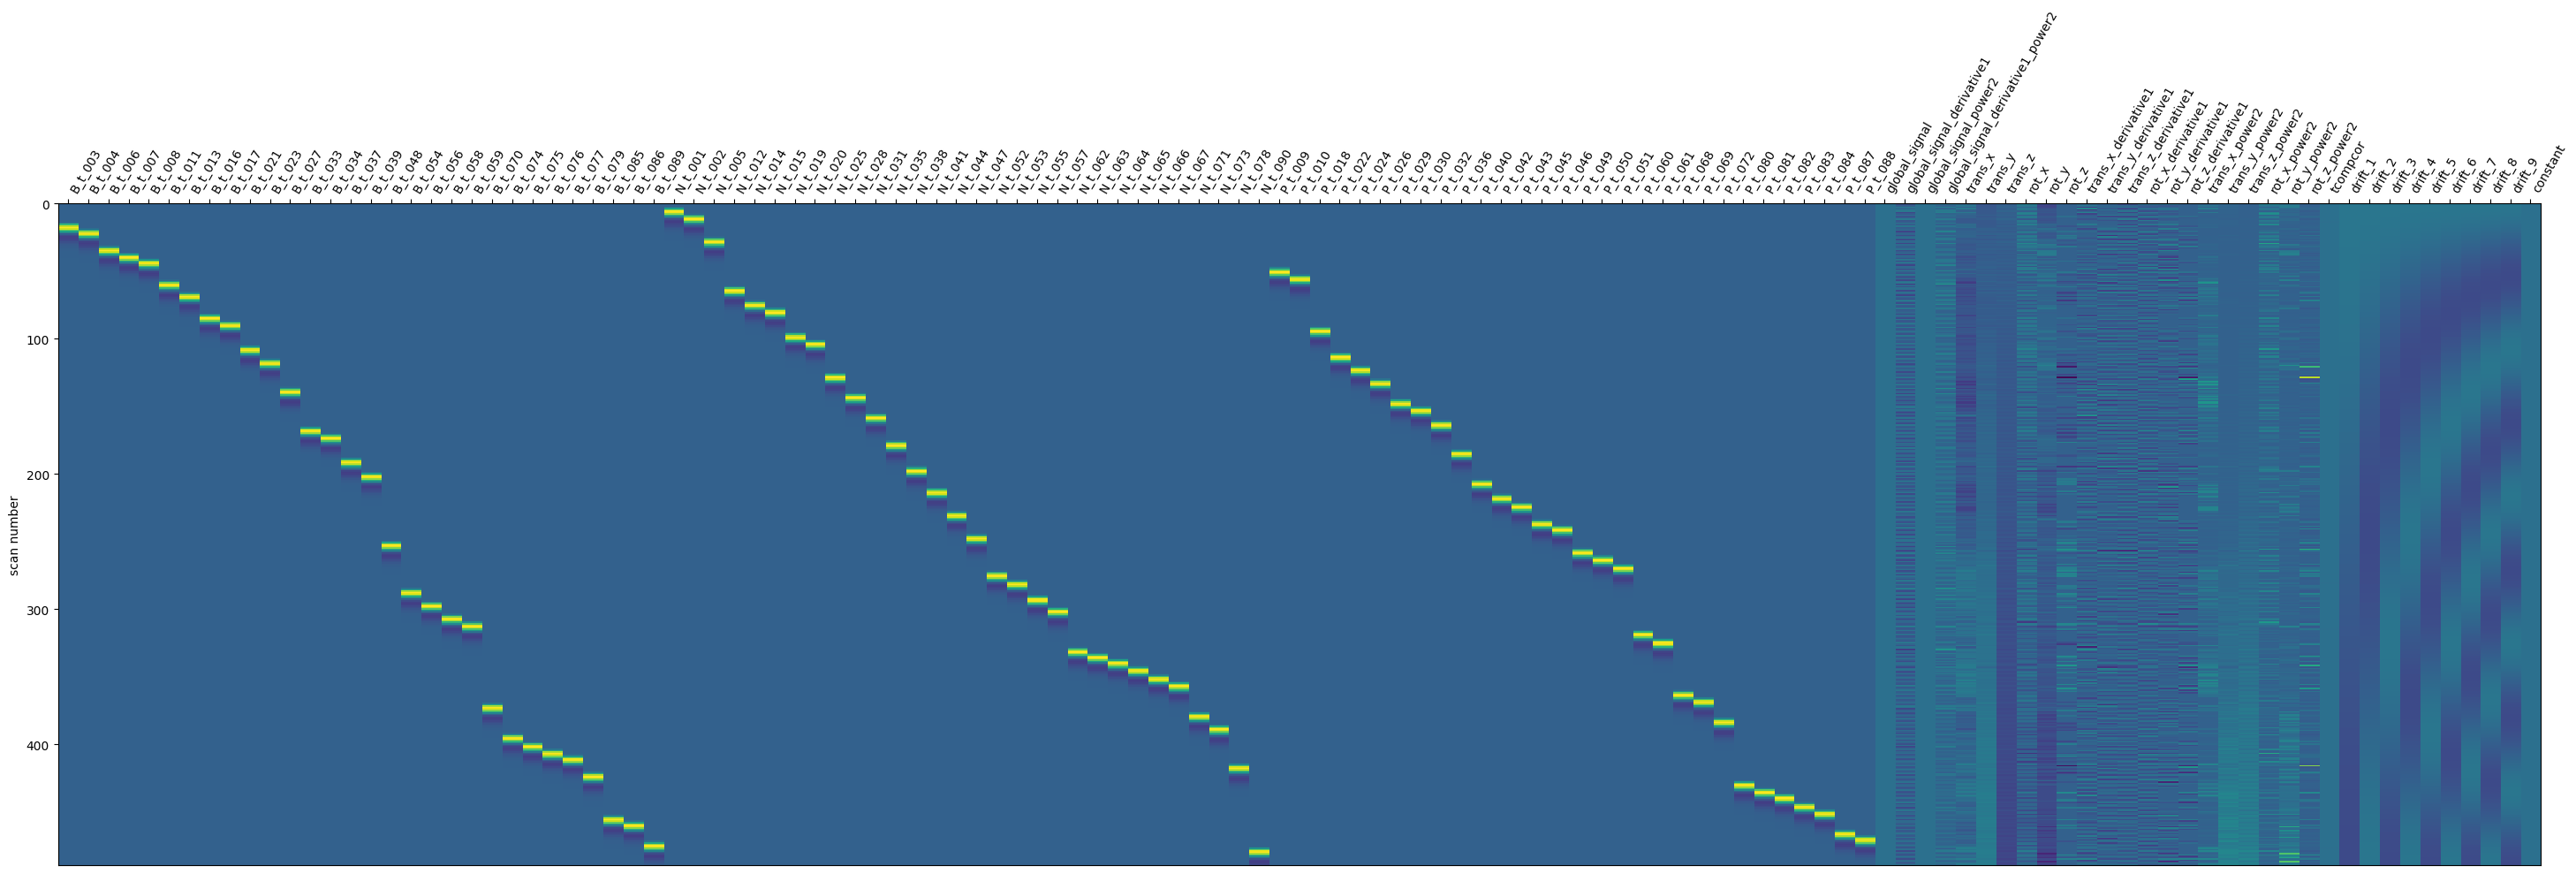

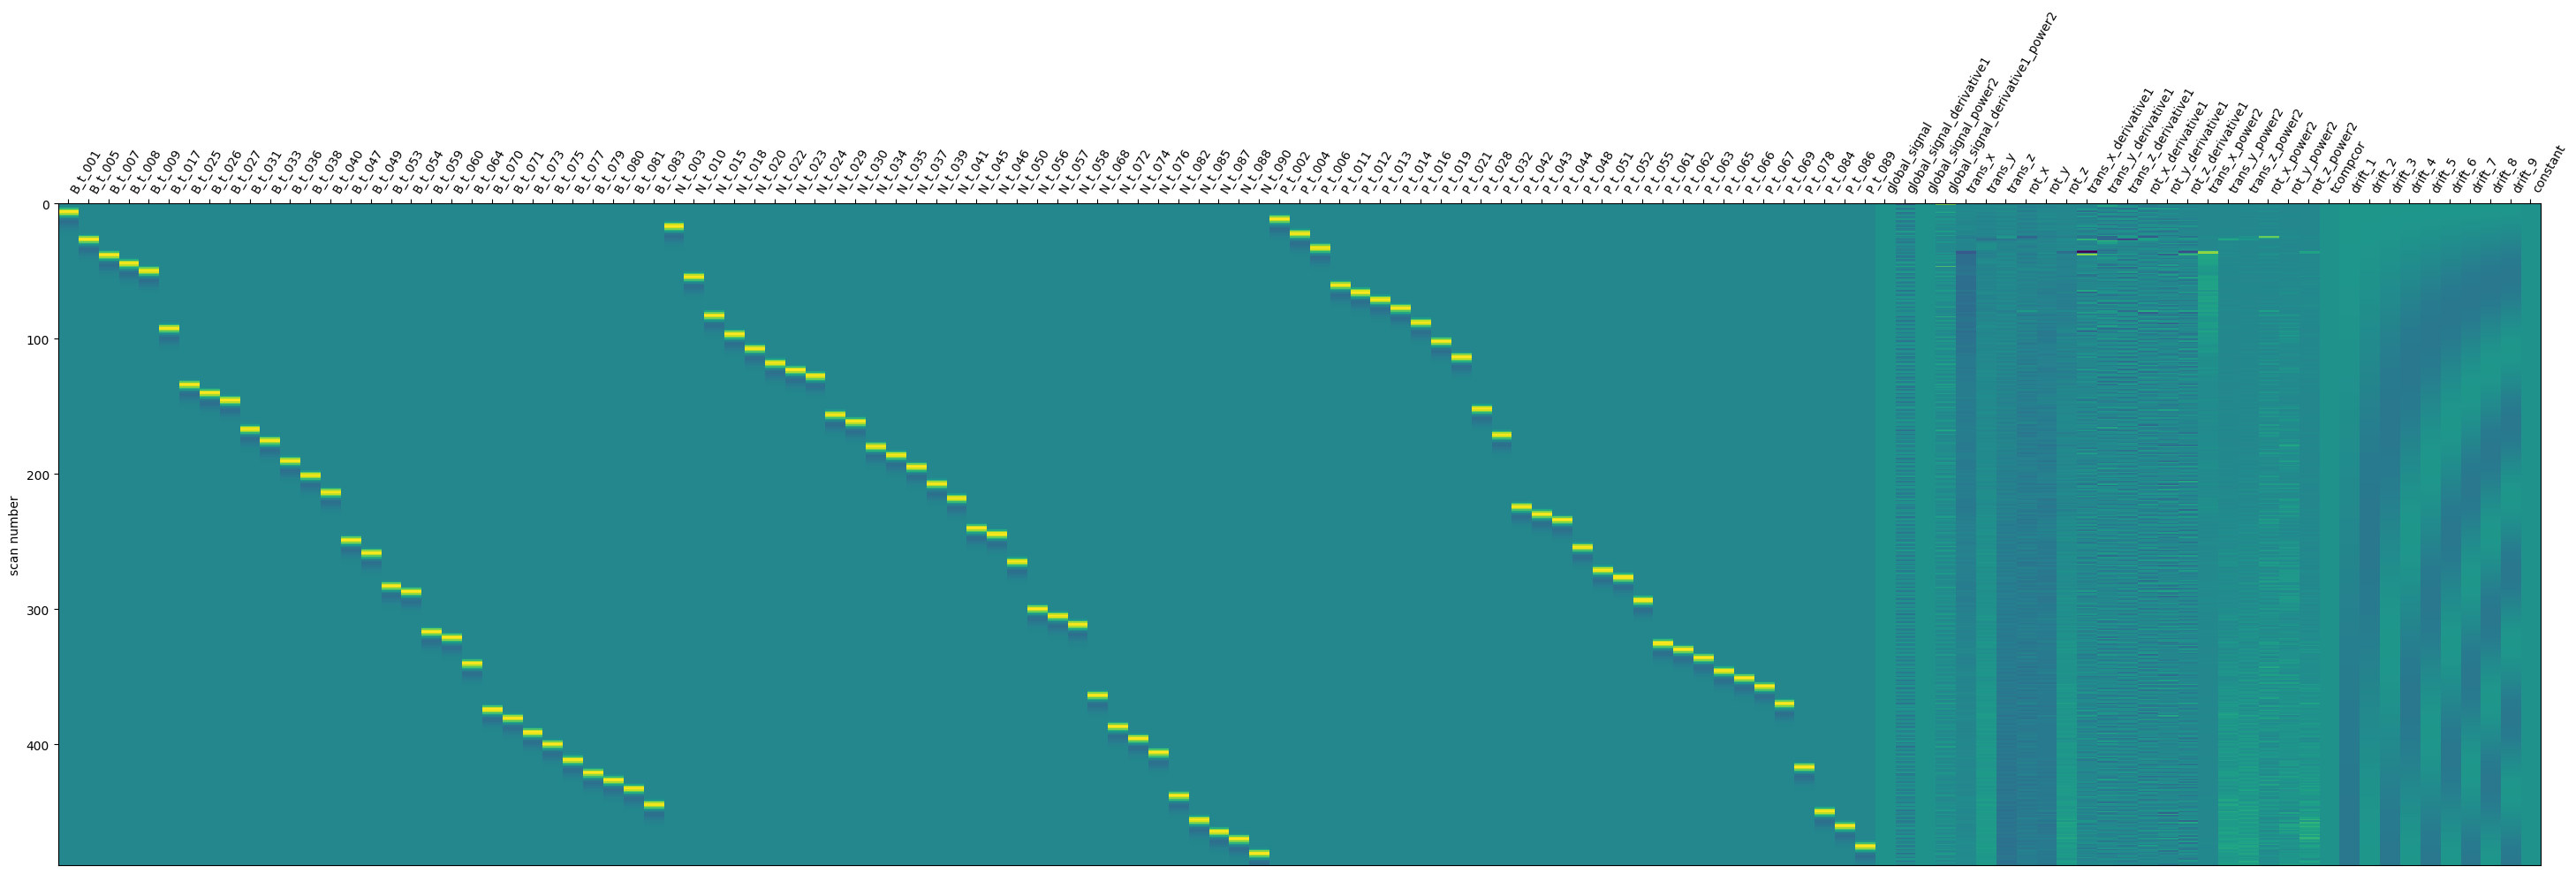

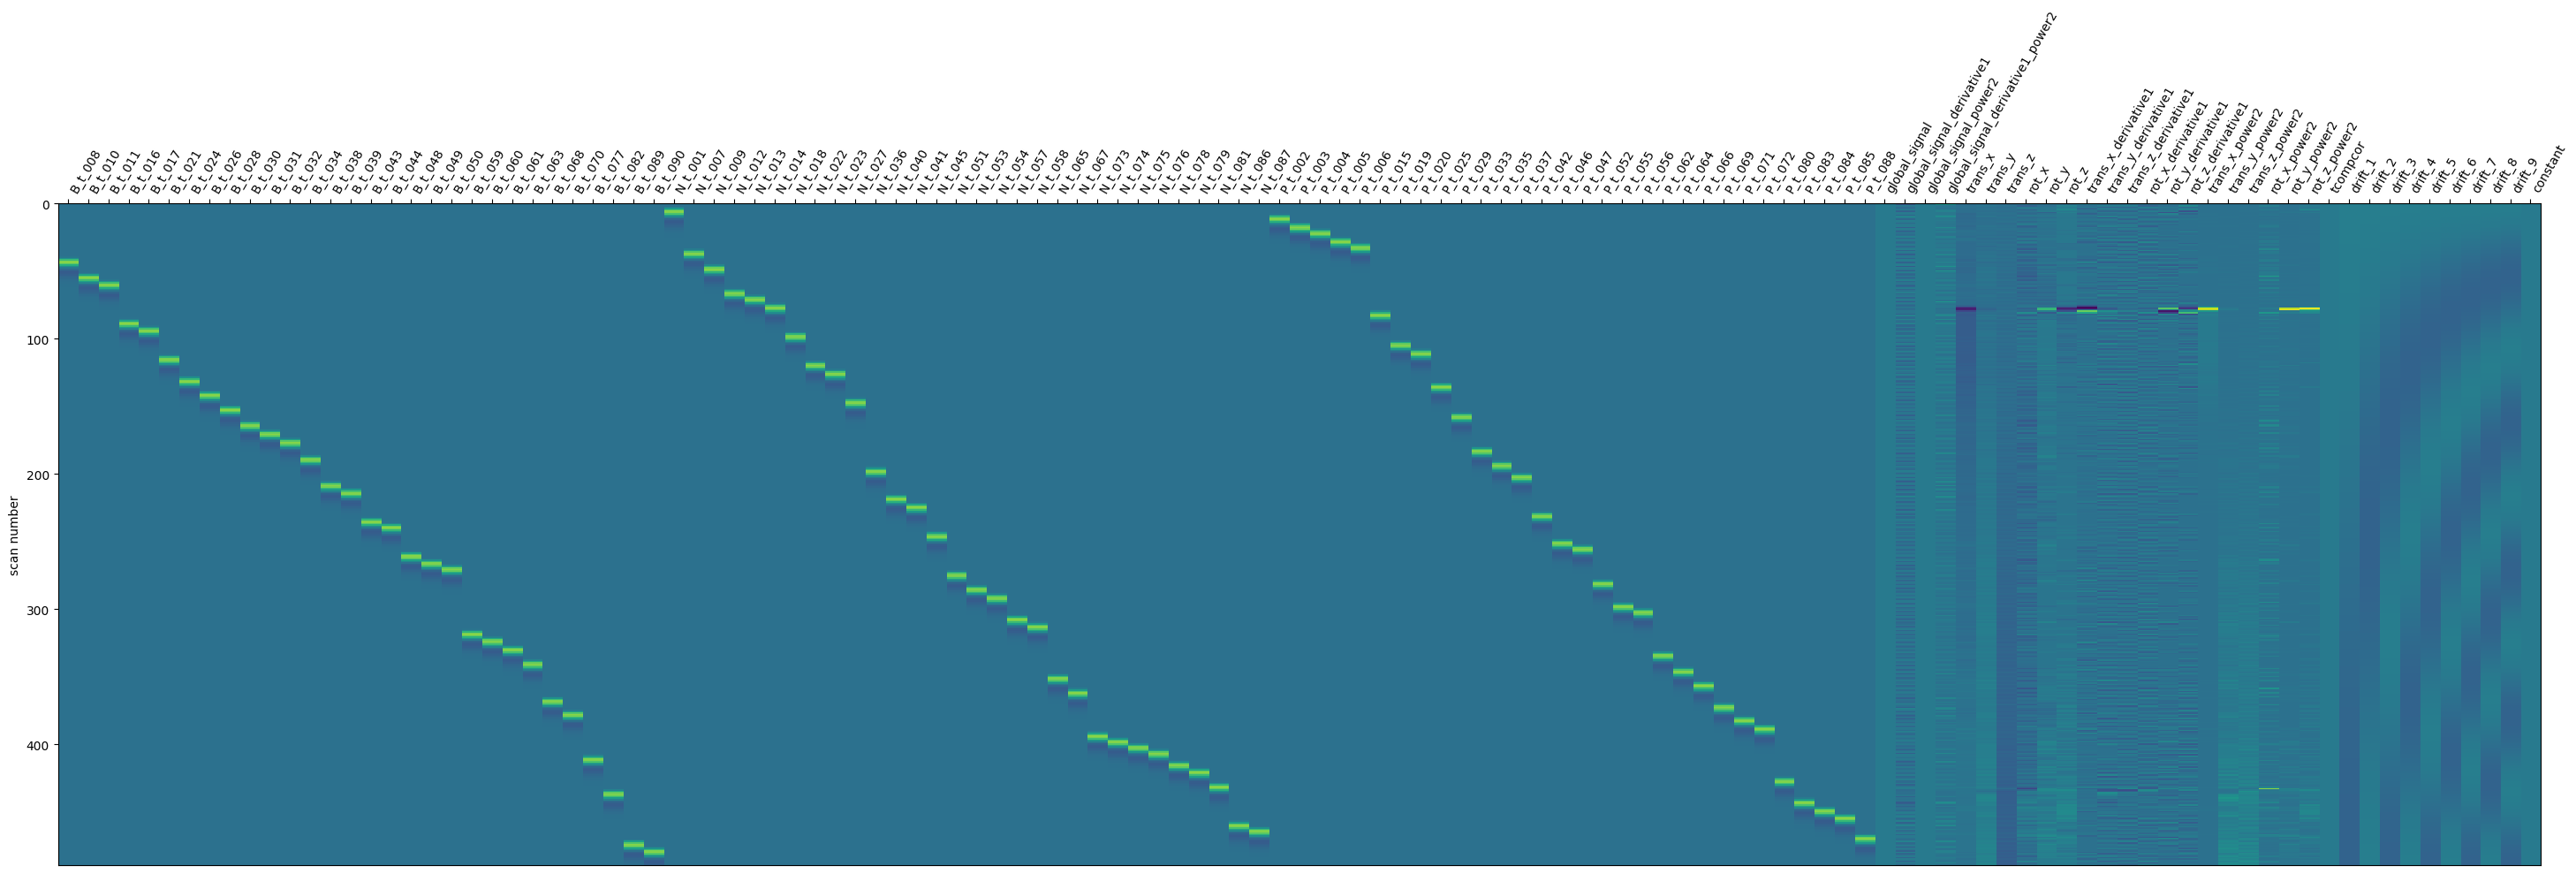

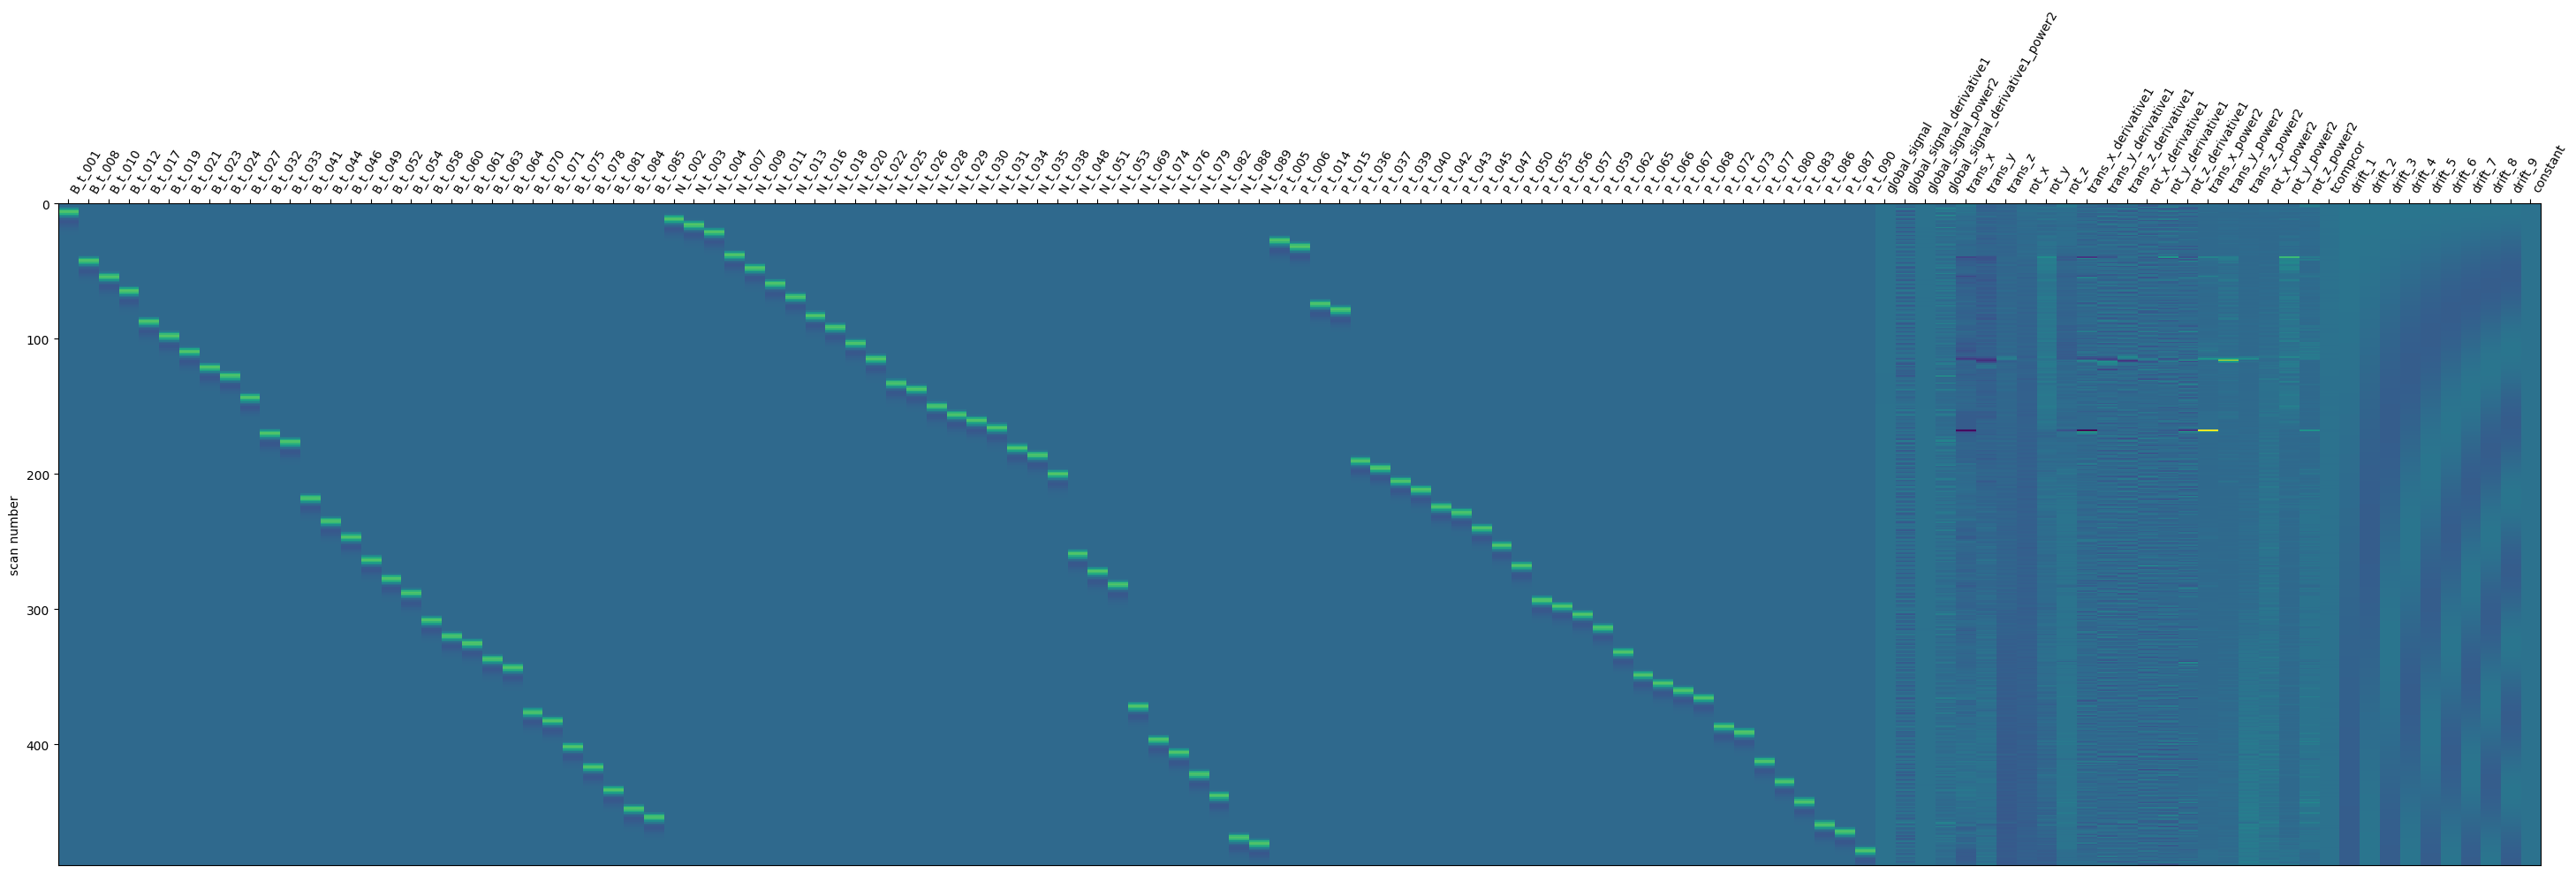

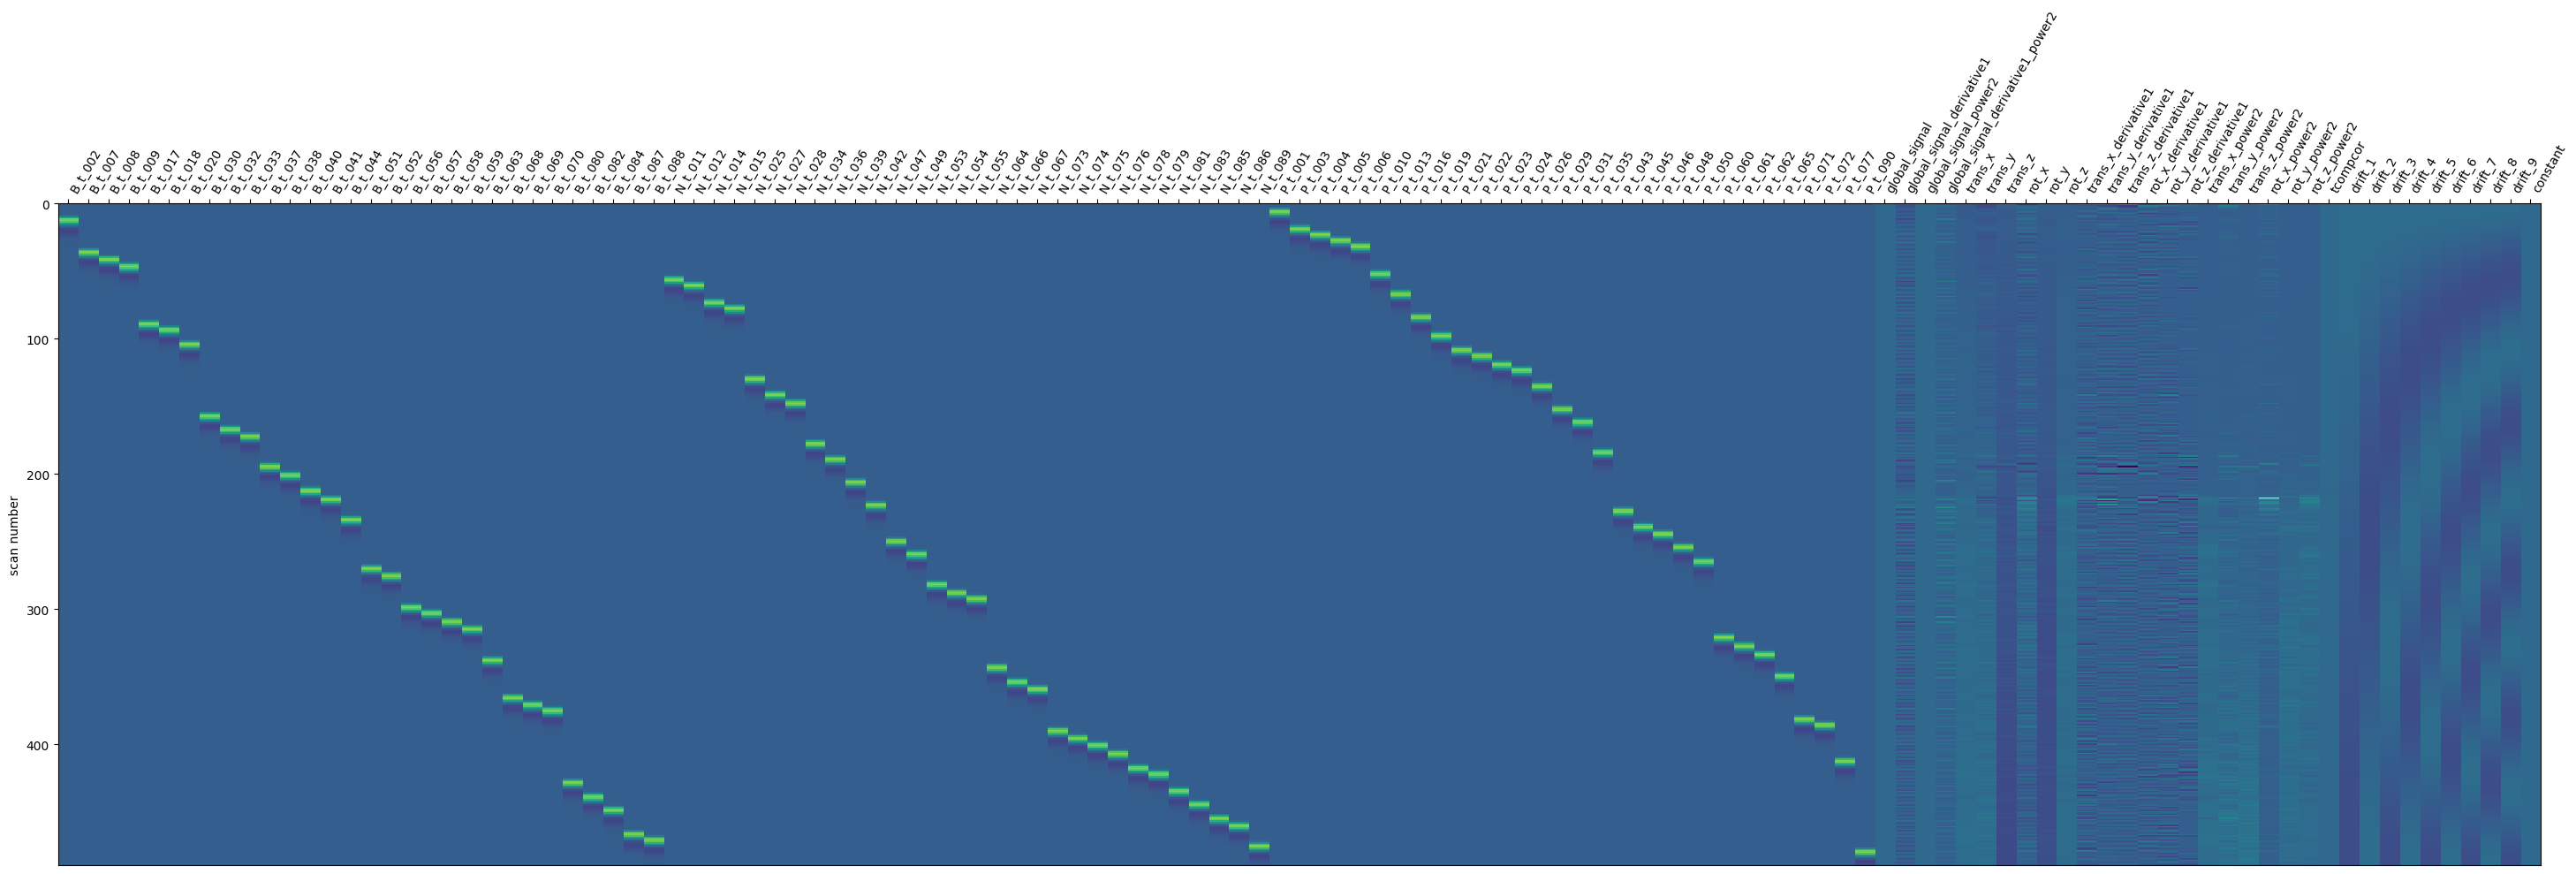

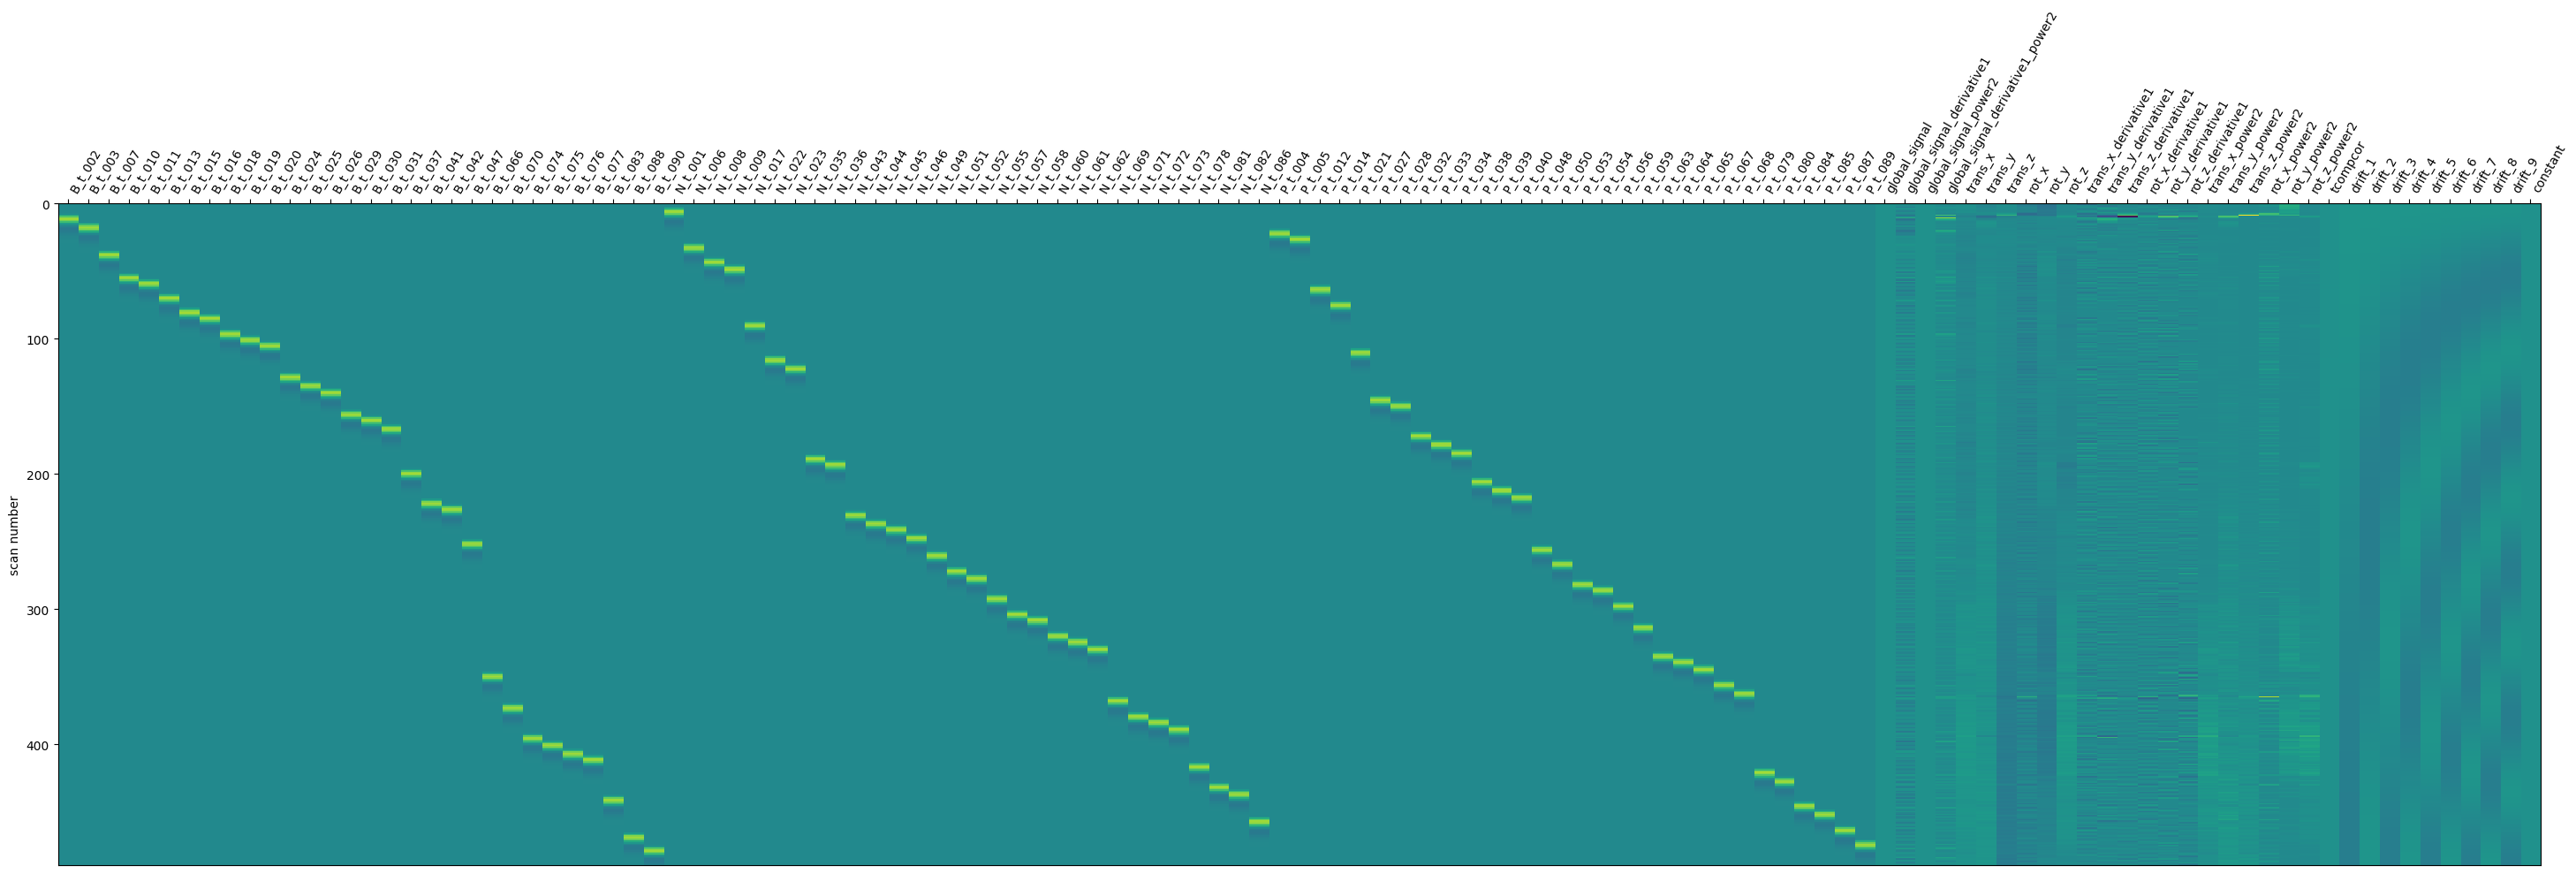

In [6]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[0])):
    plot_design_matrix(lsa_dm[ii]);

### Correlational structure

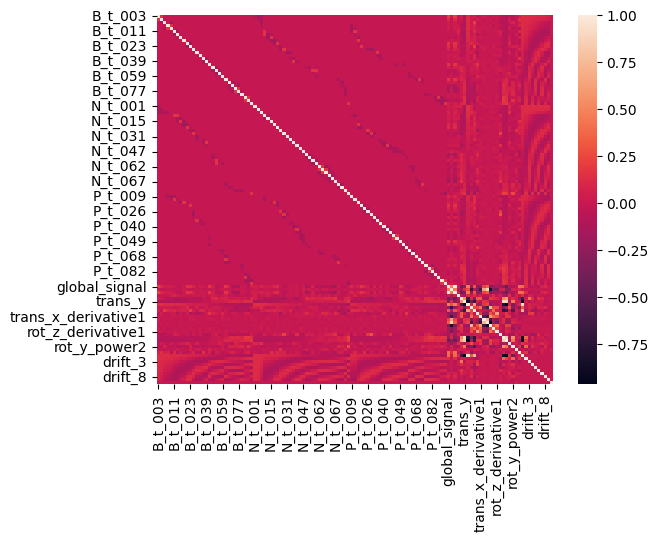

In [7]:
import seaborn as sns
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

## Fitting data

In [8]:
from nilearn.glm.first_level import FirstLevelModel

model=[]
for ii in range(len(models_events[0])):
    
    # Get data and model info for our participant, 1st session
    imgs=models_run_imgs[subject_nr][ii]
    model.append (FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model[ii].fit(imgs,design_matrices=lsa_dm[ii])

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Fitting GLM:  5
Fitting GLM:  6


### Saving it

In [9]:
import pickle

# Saving the objects
f = open('/work/fMRI_analysis/models_all_trials.pkl', 'wb')
pickle.dump([model, lsa_dm], f)
f.close()

# Reading the objects
#f = open('/work/fMRI_analysis/models_all_trials.pkl', 'rb')
#model, lsa_dm = pickle.load(f)
#f.close()

## Beta map contrasts (from the fitted model)

In [10]:
b_maps = []
conditions_label = []

for ii in range(len(models_events[0])):
    N=models_events[0][ii].shape[0]
    # Make an identity matrix with N = number of trials
    contrasts=np.eye(N)
    # Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    # Create a pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        # Add a beta-contrast image from each trial
        b_maps.append(model[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

Making contrasts for session :  1
Number of contrasts :  90
Making contrasts for session :  2
Number of contrasts :  90
Making contrasts for session :  3
Number of contrasts :  90
Making contrasts for session :  4
Number of contrasts :  90
Making contrasts for session :  5
Number of contrasts :  90
Making contrasts for session :  6
Number of contrasts :  90


### Saving it

In [11]:
import pickle

# Saving the objects
f = open('/work/fMRI_analysis/models_all_trials.pkl', 'wb')
pickle.dump([model, lsa_dm, conditions_label, b_maps], f)
f.close()

# Reading the objects
#f = open('/work/fMRI_analysis/models_all_trials.pkl', 'rb')
#model, lsa_dm, conditions_label, b_maps = pickle.load(f)
#f.close()

## Reshape for classification

In [12]:
import pickle
f = open('/work/fMRI_analysis/models_all_trials.pkl', 'rb')
model, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

import numpy as np
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)

# Concatenate beta maps
b_maps_conc=concat_imgs(b_maps)
del b_maps
# Reshaping data
from nilearn.image import index_img, concat_imgs
# Find all negative and positive trials
idx_neg=[int(i) for i in range(len(conditions_label)) if 'N_' in conditions_label[i]]
idx_pos=[int(i) for i in range(len(conditions_label)) if 'P_' in conditions_label[i]]
idx_but=[int(i) for i in range(len(conditions_label)) if 'B_' in conditions_label[i]]

for i in range(len(conditions_label)):
    if i in idx_neg:
        conditions_label[i]='N'
    if i in idx_pos:
        conditions_label[i]='P'
    if i in idx_but:
        conditions_label[i]='B'
print(conditions_label)

#We are choosing to look at positive vs negative words
idx=np.concatenate((idx_pos, idx_neg))

# Select trials
conditions=np.array(conditions_label)[idx]
print(conditions)

# Select images
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)

['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B',

## Create train and test

In [13]:
# Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# Create training and testing vars on the basis of class labels
idx_train,idx_test, conditions_train,  conditions_test = train_test_split(idx2,conditions, test_size=0.2)

# Reshaping data
from nilearn.image import index_img
fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)
# Check data sizes
print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects
f = open('/work/fMRI_analysis/model_testtrain.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test], f)
f.close()

Trial and test set shape:
(78, 92, 78, 288)
(78, 92, 78, 72)


## Searchlight analysis 

### First preparing (remember to change file path to the one running the searchlight analysis)

Making a mask for analysis: 15:39:01


/tmp/ipykernel_1468/1097623574.py:34: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


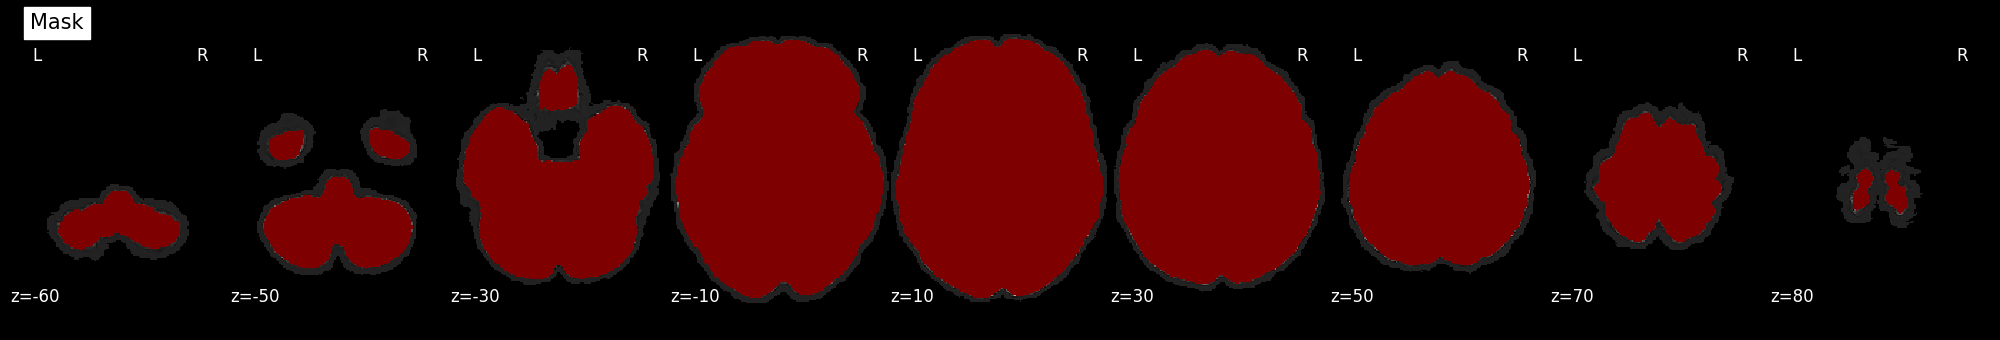

In [14]:
from datetime import datetime
now = datetime.now()
print('Making a mask for analysis:',now.strftime("%H:%M:%S"))
# -------------------
import pandas as pd
import numpy as np
from nilearn.image import new_img_like, load_img
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import decoding
from nilearn.decoding import SearchLight
from sklearn import naive_bayes, model_selection #import GaussianNB

#########################################################################
#Make a mask with the whole brain

#REMEMBER TO HAVE CORRET PATH TO THE FILE TO THE ONE RUNNING THE SEARCHLIGHT 
#mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0116/anat/sub-0116_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
#anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0122/anat/sub-0122_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

#Martines file paths
mask_wb_filename='/work/InSpePosNegData/BIDS_2023E/derivatives/sub-0122/anat/sub-0122_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/InSpePosNegData/BIDS_2023E/derivatives/sub-0122/anat/sub-0122_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

#Load the whole brain mask
mask_img = load_img(mask_wb_filename)

## This bit can be used if you want to make a smaller select of the brain to study (e.g. to speed up analsysis)
# .astype() makes a copy.
process_mask = mask_img.get_fdata().astype(int)
#Set slices below x in the z-dimension to zero (in voxel space)
process_mask[..., :10] = 0
#Set slices above x in the z-dimension to zero (in voxel space)
process_mask[..., 170:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


#Plot the mask on an anatomical background
plot_img(process_mask_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Mask", display_mode="z",cut_coords=[-60,-50,-30,-10,10,30,50,70,80],
         vmin=.40, cmap='jet', threshold=0.9, black_bg=True)


### Then running it 

In [15]:
now = datetime.now()
print('Starting searchlight analysis:',now.strftime("%H:%M:%S"))
#n_jobs=-1 means that all CPUs will be used

from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img,
    estimator=GaussianNB(),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1,
    verbose=10, cv=10)
searchlight.fit(fmri_img_train, conditions_train)

now = datetime.now()
print('Finishing searchlight analysis:',now.strftime("%H:%M:%S"))

Starting searchlight analysis: 15:39:15


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 30 concurrent workers.


## Save searchlight analysis 

In [1]:
#import pickle
#import nilearn

#Save the searchlight model

# Saving the objects:
f = open('/work/fMRI_analysis/InSpePosNeg_first_level_models_all_trials_searchlight.pkl', 'wb')
pickle.dump([searchlight, searchlight.scores_], f)
f.close()


now = datetime.now()
print('Searchlight output saved:',now.strftime("%H:%M:%S"))

NameError: name 'searchlight' is not defined

In [1]:
#Loading the data again (havent tested the function, remember to test before closing to see if its actually saved)
# Getting back the objects:
import pickle

f = open('/work/fMRI_analysis/InSpePosNeg_first_level_models_all_trials_searchlight.pkl', 'rb')
searchlight,searchlight_scores_ = pickle.load(f)
f.close()

## Plotting the outcome of the searchlight analysis 

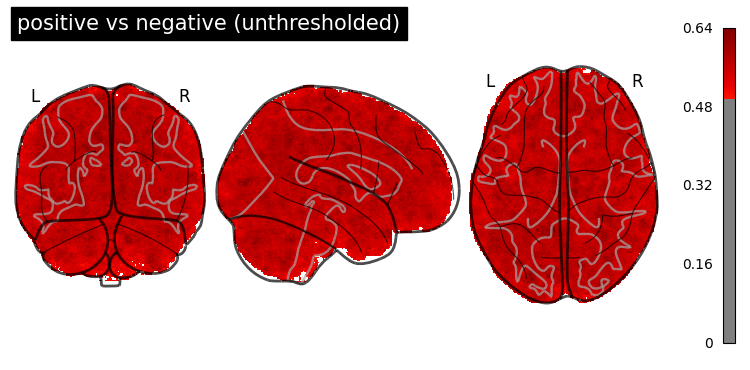

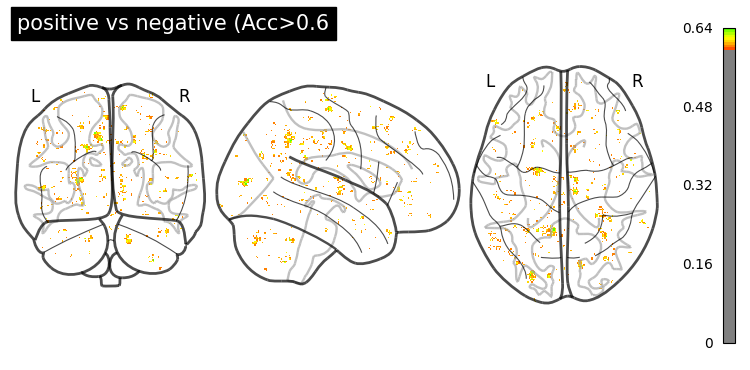

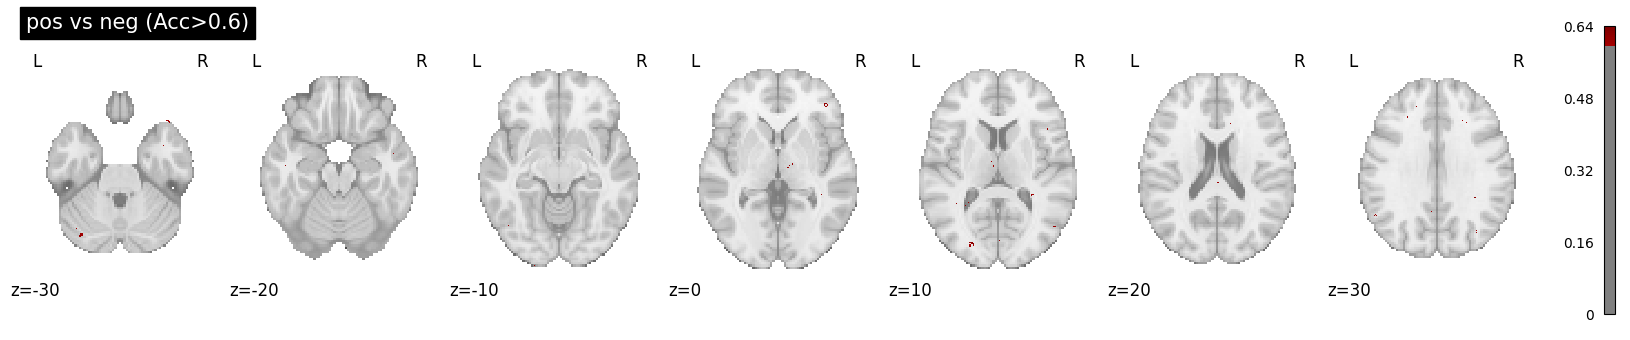

In [5]:
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img
import matplotlib.pyplot as plt
mask_wb_filename='/work/InSpePosNegData/BIDS_2023E/derivatives/sub-0122/anat/sub-0122_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/InSpePosNegData/BIDS_2023E/derivatives/sub-0122/anat/sub-0122_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

#now = datetime.now()
#print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.5,
                          title='positive vs negative (unthresholded)',
                          plot_abs=False)

fig=plotting.plot_glass_brain(searchlight_img,cmap='prism',colorbar=True,threshold=0.60,title='positive vs negative (Acc>0.6')
fig.savefig("/work/fMRI_analysis/InSpe_pos_vs_neg_searchlightNB_glass.png", dpi=300)
#plt.show()

plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='pos vs neg (Acc>0.6)')
plt.show()

### Find the 500 most predictive voxels 

In [7]:
import numpy as np

print('Number of voxels in searchlight: ',searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 500 best voxels
perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)



Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  0.6044334975369459


/tmp/ipykernel_1027/3066345679.py:21: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)


### Visualization of the voxels

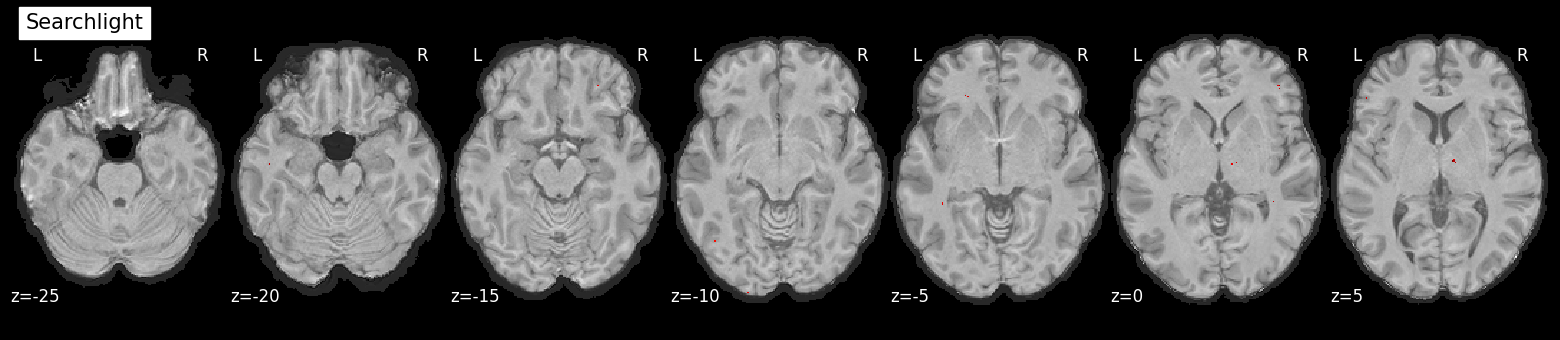

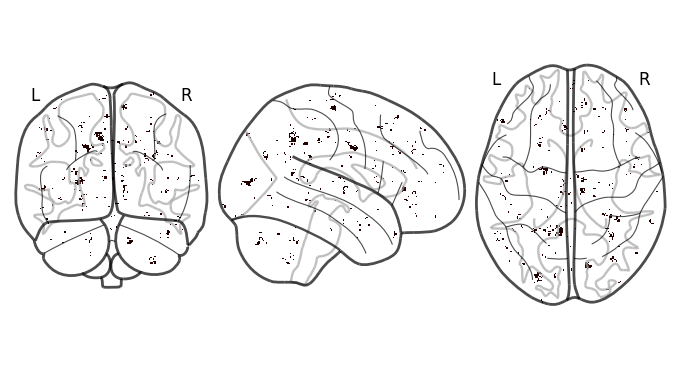

In [9]:
# --------------
from nilearn import image
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import plotting
%matplotlib inline
#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
#Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
fig=plotting.plot_glass_brain(searchlight_img,threshold=cut)
fig.savefig("/work/fMRI_analysis/InSpe_pos_vs_neg_searchlightNB_glass_500.png", dpi=300)

#now = datetime.now()
#print('Saving glass brain with 500 most predictive voxels:',now.strftime("%H:%M:%S"))

### Make a permutation classification test on the 2nd data split using the best voxels

In [15]:
from sklearn.naive_bayes import GaussianNB
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)

# Loading fmri_img_test
f = open('/work/fMRI_analysis/model_testtrain.pkl', 'rb')
fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test = pickle.load(f)
f.close()

#now = datetime.now()
#print('Perform permutation test on test set using 500 predictive voxels:',now.strftime("%H:%M:%S"))

# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

from sklearn.model_selection import permutation_test_score
score_cv_test, scores_perm, pvalue= permutation_test_score(
    GaussianNB(), fmri_masked, conditions_test, cv=10, n_permutations=1000, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score_cv_test, pvalue))



/work/fMRI_analysis/venvs/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(72, 490)
Classification Accuracy: 0.45892857142857146 (pvalue : 0.7642357642357642)


## Saving permutation outcomes

In [17]:
import pickle

#now = datetime.now()
#print('Saving permutation scores:',now.strftime("%H:%M:%S"))
# Save the permutation scores

# Saving the objects:
f = open('/work/fMRI_analysis/InSpe_pos_vs_neg_first_level_models_all_trials_searchlight_perms.pkl', 'wb')
pickle.dump([score_cv_test, scores_perm, pvalue], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'rb')
#score_cv_test, scores_perm, pvalue = pickle.load(f)
#f.close()

### View a histogram of permutation scores

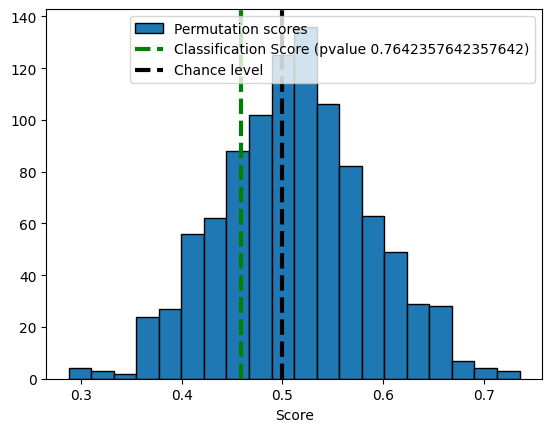

In [18]:
import numpy as np
import matplotlib.pyplot as plt

#now = datetime.now()
#print('Plotting and saving permutation scores:',now.strftime("%H:%M:%S"))


# How many classes
n_classes = np.unique(conditions_test).size

plt.hist(scores_perm, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score_cv_test], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

plt.savefig("/work/fMRI_analysis/InSpe_pos_vs_neg_one_sub_perm.png", dpi=300)
plt.show()